# Fire Hazard Incidents Analytics Pipeline

## Importing Required Libraries

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from storedb import save_in_db, IMG_PATH
import matplotlib.pyplot as plt

## Creating Spark Session and using all available cores

In [6]:
spark = SparkSession \
    .builder \
    .appName("532: Project") \
    .config("local[4]") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/11 19:33:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Loading civilian casuality, firefighter casuality, fire incidents and basic module data

In [7]:
civilian_casualities_df = spark.read.options(delimiter="^", header=True).csv("civiliancasualty.txt")
firefighter_casualities_df = spark.read.options(delimiter="^", header=True).csv("ffcasualty.txt")
basic_module_df = spark.read.options(delimiter="^", header=True).csv("basicincident.txt")
fire_incidents_df = spark.read.options(delimiter="^", header=True).csv("fireincident.txt")

In [8]:
# Dropping null values in loss tables and finding total loss
basic_module_df = basic_module_df.na.drop(subset=("PROP_LOSS","CONT_LOSS"))
total_loss = basic_module_df.groupBy("INCIDENT_KEY").agg(F.sum(basic_module_df.PROP_LOSS + basic_module_df.CONT_LOSS).alias("TOTAL_LOSS"))

In [9]:
# Finding Civilian Injury Severity vs. Dollar Loss
civilian_dollar_loss = total_loss.join(civilian_casualities_df, total_loss.INCIDENT_KEY == civilian_casualities_df.INCIDENT_KEY)
cdl_df = civilian_dollar_loss.groupBy("SEV").agg(F.avg("TOTAL_LOSS").alias("AVG_LOSS"))
p_cdl_df = cdl_df.toPandas()
p_cdl_df["AVG_LOSS"] = p_cdl_df["AVG_LOSS"]/1000

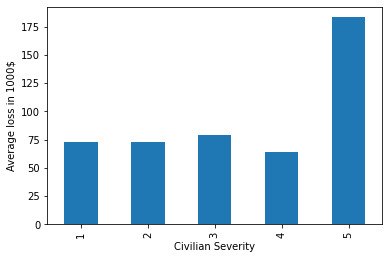

In [12]:
p1 = p_cdl_df.drop([2]).sort_values(by="SEV").plot(x="SEV", y="AVG_LOSS", xlabel="Civilian Severity", ylabel = "Average loss in 1000$", kind="bar", legend = False)
fig1 = p1.get_figure()
fig1.savefig(f"{IMG_PATH}civilian_dollar_loss.png")
save_in_db("civilian_dollar_loss.png", "p1")

In [102]:
# Finding Firefighter Injury Severity vs. Dollar Loss
firefighter_dollar_loss = total_loss.join(firefighter_casualities_df, total_loss.INCIDENT_KEY == firefighter_casualities_df.INCIDENT_KEY)
ffdl_df = firefighter_dollar_loss.groupBy("SEVERITY").agg(F.avg("TOTAL_LOSS").alias("AVG_LOSS"))
p_ffdl_df = ffdl_df.toPandas()

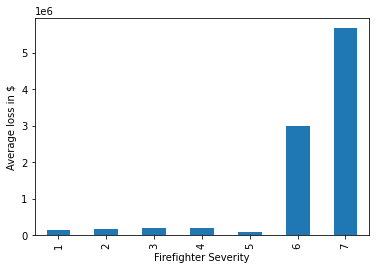

In [103]:
p2 = p_ffdl_df.drop([3]).sort_values(by="SEVERITY").plot(x="SEVERITY", y="AVG_LOSS", xlabel="Firefighter Severity", ylabel = "Average loss in $", kind="bar", legend = False)
fig2 = p2.get_figure()
fig2.savefig("ff_dollar_loss.png")

In [105]:
# Formatting datetime columns
basic_time_module_df = basic_module_df.withColumn("ALARM_TIME", F.to_timestamp("ALARM","MMddyyyyHHmm")).withColumn("CONT_TIME", F.to_timestamp("INC_CONT","MMddyyyyHHmm")).withColumn("ARV_TIME", F.to_timestamp("ARRIVAL","MMddyyyyHHmm"))

In [106]:
# Finding Civilian Casualty vs. Total Fire Time(in seconds)
total_fire_time_df = basic_time_module_df.withColumn("TOTAL_FIRE_TIME", basic_time_module_df.CONT_TIME.cast("long") - basic_time_module_df.ALARM_TIME.cast("long"))
civilian_casualty_fire_time = total_fire_time_df.join(civilian_casualities_df, total_fire_time_df.INCIDENT_KEY == civilian_casualities_df.INCIDENT_KEY)
ccft_df = civilian_casualty_fire_time.groupBy("SEV").agg(F.avg("TOTAL_FIRE_TIME").alias("AVG_FIRE_TIME"))
p_ccft_df = ccft_df.toPandas()
p_ccft_df["AVG_FIRE_TIME"] = p_ccft_df["AVG_FIRE_TIME"]/60

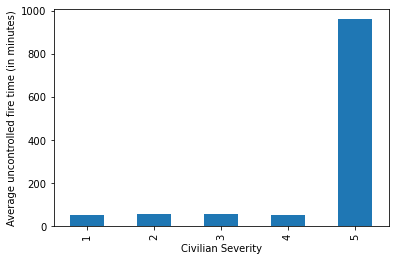

In [107]:
p3 = p_ccft_df.drop([2]).sort_values(by="SEV").plot(x="SEV", y="AVG_FIRE_TIME", xlabel="Civilian Severity", ylabel = "Average uncontrolled fire time (in minutes)", kind="bar", legend = False)
fig3 = p3.get_figure()
fig3.savefig("civ_fire_time.png")

In [108]:
ff_response_time = basic_time_module_df.withColumn("FF_RESPONSE_TIME", basic_time_module_df.CONT_TIME.cast("long") - basic_time_module_df.ARV_TIME.cast("long"))
ff_severity_response_time = ff_response_time.join(firefighter_casualities_df, ff_response_time.INCIDENT_KEY == firefighter_casualities_df.INCIDENT_KEY)
ffrt_df = ff_severity_response_time.groupBy("SEVERITY").agg(F.avg("FF_RESPONSE_TIME").alias("AVG_RSP_TIME"))
p_ffrt_df = ffrt_df.toPandas()
p_ffrt_df["AVG_RSP_TIME"] = p_ffrt_df["AVG_RSP_TIME"]/3600

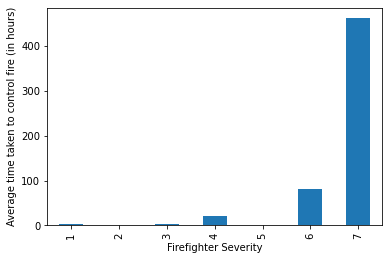

In [109]:
p4 = p_ffrt_df.drop([3]).sort_values(by="SEVERITY").plot(x="SEVERITY", y="AVG_RSP_TIME", xlabel="Firefighter Severity", ylabel = "Average time taken to control fire (in hours)", kind="bar", legend = False)
fig4 = p4.get_figure()
fig4.savefig("ff_fire_time.png")

In [191]:
ignition_cause = fire_incidents_df.na.drop(subset=("CAUSE_IGN"))

In [111]:
ignition_cause_vs_loss = total_loss.join(ignition_cause, total_loss.INCIDENT_KEY == ignition_cause.INCIDENT_KEY)
cause_loss_df = ignition_cause_vs_loss.groupBy("CAUSE_IGN").agg(F.sum("TOTAL_LOSS").alias("DLR_LOSS"))
p_cause_loss_df = cause_loss_df.toPandas()
p_cause_loss_df["DLR_LOSS"] = p_cause_loss_df["DLR_LOSS"]/1e09

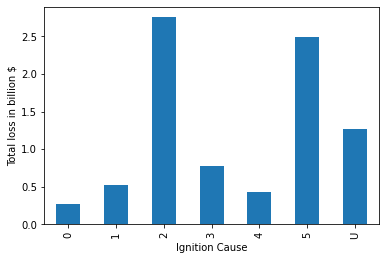

In [112]:
p5 = p_cause_loss_df.sort_values(by="CAUSE_IGN").plot(x="CAUSE_IGN", y="DLR_LOSS", xlabel="Ignition Cause", ylabel = "Total loss in billion $", kind="bar", legend = False)
fig5 = p5.get_figure()
fig5.savefig("cause_dollar_loss.png")

# Month vs Major states vs Types of fire

In [745]:
incident_state = basic_module_df.select("INCIDENT_KEY", "STATE", "INC_DATE")
incident_state.groupBy('STATE').count().sort(F.desc("count")).show()

# selecting top 10 states
incident_state = incident_state.withColumn("INC_MONTH", F.month(F.to_date(incident_state.INC_DATE,"MMddyyyy")))

incidents_ca = incident_state.filter(incident_state.STATE == "CA").groupBy("INC_MONTH").count()
incidents_tx = incident_state.filter(incident_state.STATE == "TX").groupBy("INC_MONTH").count()
incidents_pa = incident_state.filter(incident_state.STATE == "PA").groupBy("INC_MONTH").count()
incidents_fl = incident_state.filter(incident_state.STATE == "FL").groupBy("INC_MONTH").count()
incidents_oh = incident_state.filter(incident_state.STATE == "OH").groupBy("INC_MONTH").count()
incidents_ny = incident_state.filter(incident_state.STATE == "NY").groupBy("INC_MONTH").count()
incidents_il = incident_state.filter(incident_state.STATE == "IL").groupBy("INC_MONTH").count()
incidents_ga = incident_state.filter(incident_state.STATE == "GA").groupBy("INC_MONTH").count()
incidents_nc = incident_state.filter(incident_state.STATE == "NC").groupBy("INC_MONTH").count()
incidents_mi = incident_state.filter(incident_state.STATE == "MI").groupBy("INC_MONTH").count()
incidents_ma = incident_state.filter(incident_state.STATE == "MA").groupBy("INC_MONTH").count()

# incidents_ca.show()
# incidents_tx.show()
# incidents_ma.show()

+-----+------+
|STATE| count|
+-----+------+
|   CA|144036|
|   TX| 94231|
|   PA| 92031|
|   FL| 69808|
|   OH| 69475|
|   NY| 62552|
|   IL| 55041|
|   GA| 51846|
|   NC| 51489|
|   MI| 50708|
|   MA| 50192|
|   IN| 37987|
|   VA| 36658|
|   SC| 35597|
|   MN| 34495|
|   TN| 34084|
|   WA| 33666|
|   NJ| 29644|
|   OK| 26207|
|   CO| 25135|
+-----+------+
only showing top 20 rows



In [746]:
inc_ca_df = incidents_ca.toPandas()
inc_tx_df = incidents_tx.toPandas()
inc_pa_df = incidents_pa.toPandas()
inc_fl_df = incidents_fl.toPandas()
inc_oh_df = incidents_oh.toPandas()
inc_ny_df = incidents_ny.toPandas()
inc_il_df = incidents_il.toPandas()
inc_ga_df = incidents_ga.toPandas()
inc_nc_df = incidents_nc.toPandas()
inc_mi_df = incidents_mi.toPandas()
inc_ma_df = incidents_ma.toPandas()

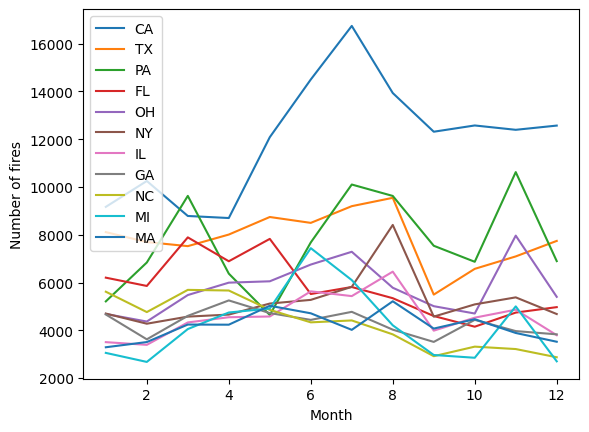

In [747]:
t1 = inc_ca_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count")
inc_tx_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_pa_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_fl_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_oh_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_ny_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_il_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_ga_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_nc_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_mi_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_ma_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", xlabel = "Month", ylabel = "Number of fires", ax = t1).get_figure()
plt.legend(["CA", "TX", "PA", "FL", "OH", "NY", "IL", "GA", "NC", "MI", "MA"])
plt.savefig("state_inc.png")

In [20]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.mllib.stat import Statistics

In [24]:
fire_incidents_df2 = spark.read.options(delimiter="^", header=True, inferSchema = True).csv("fireincident.txt")

In [46]:
assembler = VectorAssembler(inputCols=['ACRES_BURN','NO_SPR_OP'], 
                            outputCol="TEST_2")
myGraph_vector = assembler.transform(fire_incidents_df2).select("TEST_2")


In [42]:
fire_incidents_df2 = fire_incidents_df2.na.drop(subset=("ACRES_BURN","BLDG_INVOL"))

In [47]:
matrix = Correlation.corr(myGraph_vector, "TEST_2").collect()[0][0]
corrmatrix = matrix.toArray().tolist()
print(corrmatrix)

[[1.0, 0.011001063463876144], [0.011001063463876144, 1.0]]


In [47]:
wildlands_df = spark.read.options(delimiter="^", header=True).csv("wildlands.txt")

In [109]:
wildlands_df = wildlands_df.na.drop(subset=("WIND_SPEED","AIR_TEMP","REL_HUMID","ACRES_BURN"))
wildlands_df = wildlands_df.withColumn("WIND_SPEED", F.col("WIND_SPEED").cast(IntegerType())).withColumn("AIR_TEMP", F.col("AIR_TEMP").cast(IntegerType())).withColumn("REL_HUMID", F.col("REL_HUMID").cast(IntegerType())).withColumn("ACRES_BURN", F.col("ACRES_BURN").cast(IntegerType()))

In [143]:
wildlands_df = wildlands_df.filter(wildlands_df["AIR_TEMP"]!=0)

In [144]:
assembler = VectorAssembler(inputCols=["WIND_SPEED","AIR_TEMP","REL_HUMID"], 
                            outputCol="features")
myGraph_vector = assembler.transform(wildlands_df).select(["features","ACRES_BURN"])
# matrix = Correlation.corr(myGraph_vector, ["TEST_2"])
# corrmatrix = matrix.toArray().tolist()
# print(corrmatrix)

In [145]:
myGraph_vector.show()

+----------------+----------+
|        features|ACRES_BURN|
+----------------+----------+
|[10.0,41.0,85.0]|        70|
| [6.0,59.0,37.0]|         0|
|[10.0,72.0,30.0]|         2|
| [8.0,66.0,45.0]|         1|
|[10.0,69.0,32.0]|         1|
| [7.0,52.0,32.0]|        10|
| [5.0,70.0,50.0]|         0|
| [2.0,82.0,50.0]|        20|
|[15.0,80.0,44.0]|         1|
| [10.0,44.0,0.0]|         0|
|[12.0,68.0,62.0]|         1|
|[10.0,81.0,57.0]|         3|
| [6.0,82.0,55.0]|         3|
|[14.0,70.0,51.0]|         0|
| [8.0,86.0,34.0]|         0|
| [8.0,84.0,54.0]|         0|
| [7.0,81.0,69.0]|         0|
| [5.0,83.0,67.0]|        30|
| [8.0,74.0,78.0]|         0|
| [7.0,67.0,95.0]|         3|
+----------------+----------+
only showing top 20 rows



In [146]:
splits = myGraph_vector.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

In [147]:
lr = LinearRegression(featuresCol = 'features', labelCol='ACRES_BURN', maxIter=1000, regParam=0.3)

In [148]:
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [6.34953860317282,3.8658419567338047,2.5338798717579896]
Intercept: -211.50210872298427


In [149]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 5670.924386
r2: 0.000599


In [150]:
train_df.describe().show()

+-------+-----------------+
|summary|       ACRES_BURN|
+-------+-----------------+
|  count|             7423|
|   mean|216.3626566078405|
| stddev| 5673.00676593406|
|    min|                0|
|    max|           387393|
+-------+-----------------+



In [151]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","features","ACRES_BURN").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="ACRES_BURN",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-------------------+----------------+----------+
|         prediction|        features|ACRES_BURN|
+-------------------+----------------+----------+
| 155.71739017765177| [0.0,36.0,90.0]|         0|
| 181.05618889523166|[0.0,36.0,100.0]|         0|
|  127.9747558865075| [0.0,38.0,76.0]|         1|
|-27.663789779318392| [0.0,41.0,10.0]|         1|
| 185.18211944835272| [0.0,41.0,94.0]|         0|
+-------------------+----------------+----------+
only showing top 5 rows

R Squared (R2) on test data = -0.00132187


In [60]:
hazmat_df = spark.read.options(delimiter="^", header=True).csv("hazchem.txt")

In [95]:
hazmat_dollar_loss = total_loss.join(hazmat_df, total_loss.INCIDENT_KEY == hazmat_df.INCIDENT_KEY)

In [78]:
hazmat_dollar_loss.count()

5851

In [68]:
from pyspark.sql.types import IntegerType

In [96]:
hazmat_dollar_loss = hazmat_dollar_loss.na.drop(subset=("AMOUNT_REL","TOTAL_LOSS")).withColumn("AMOUNT_REL", F.col("AMOUNT_REL").cast(IntegerType()))

In [97]:
hazmat_dollar_loss = hazmat_dollar_loss.filter(hazmat_dollar_loss.CHEM_NAME == "995")

In [98]:
assembler = VectorAssembler(inputCols=["AMOUNT_REL"], 
                            outputCol="TEST_2")
myGraph_vector = assembler.transform(hazmat_dollar_loss).select(["TEST_2","TOTAL_LOSS"])
# matrix = Correlation.corr(myGraph_vector, ["TEST_2","TOTAL_LOSS"])
# corrmatrix = matrix.toArray().tolist()
# print(corrmatrix)

In [71]:
hazmat_dollar_loss.select("CHEM_NAME").show()

+--------------------+
|           CHEM_NAME|
+--------------------+
|                 995|
|                 995|
|                3233|
|                 OIL|
|             0059000|
|                 124|
|             0024000|
|                 995|
|                 995|
| Sodium hydroxidedry|
|                 995|
|                 625|
|         natural gas|
|             0341000|
|                 995|
|                3196|
|Liquefied petrole...|
|                1114|
|                 625|
|                 995|
+--------------------+
only showing top 20 rows



In [100]:
splits = myGraph_vector.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

In [104]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'TEST_2', labelCol='TOTAL_LOSS', maxIter=1000, regParam=0.3)


In [105]:
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [3.8150060421602943]
Intercept: 1736.564260291503


In [106]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 16868.693860
r2: 0.004616


In [107]:
train_df.describe().show()

+-------+------------------+
|summary|        TOTAL_LOSS|
+-------+------------------+
|  count|               143|
|   mean|1960.7692307692307|
| stddev|16967.193783801573|
|    min|               0.0|
|    max|          200000.0|
+-------+------------------+



In [108]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","TEST_2","TOTAL_LOSS").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="TOTAL_LOSS",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+------+----------+
|        prediction|TEST_2|TOTAL_LOSS|
+------------------+------+----------+
|1740.3792663336633| [1.0]|       0.0|
|1740.3792663336633| [1.0]|       0.0|
|1740.3792663336633| [1.0]|       0.0|
| 1774.714320713106|[10.0]|       0.0|
|1812.8643811347088|[20.0]|       0.0|
+------------------+------+----------+
only showing top 5 rows

R Squared (R2) on test data = -0.0148379


In [8]:
basic_module_df.select("OTH_INJ").distinct().show()
fire_incidents_df.select("NO_SPR_OP").distinct().show()
fire_incidents_df.select("ACRES_BURN").distinct().show()
fire_incidents_df.select("BLDG_INVOL").distinct().show()

+-------+
|OTH_INJ|
+-------+
|      7|
|      3|
|      0|
|   null|
|      1|
|      4|
|      2|
|      8|
|      5|
|      6|
|     10|
|     29|
|      9|
|     20|
|     12|
|     11|
+-------+



In [16]:
fire_incidents_df.select("NO_SPR_OP").count()

542192

In [31]:
fire_incidents_df.select("BLDG_INVOL").count()

542192

In [33]:
fire_incidents_df.select("NO_SPR_OP").count()
fire_incidents_df_na = fire_incidents_df.na.drop(subset=["NO_SPR_OP"])
fire_incidents_df_na.select("NO_SPR_OP").count()

5545

In [34]:
fire_incidents_df_na.select("NO_SPR_OP").distinct().show()

+---------+
|NO_SPR_OP|
+---------+
|        7|
|        3|
|        8|
|        0|
|        5|
|        6|
|       40|
|       25|
|        9|
|        1|
|       20|
|       10|
|        4|
|        2|
|      100|
|      150|
|      200|
|       60|
|       13|
|       45|
+---------+
only showing top 20 rows



In [35]:
fire_incidents_df_na.groupBy("NO_SPR_OP").count().show()

+---------+-----+
|NO_SPR_OP|count|
+---------+-----+
|        7|   12|
|        3|  162|
|        8|   19|
|        0| 1940|
|        5|   40|
|        6|   42|
|       40|    2|
|       25|    3|
|        9|    6|
|        1| 2594|
|       20|    6|
|       10|   30|
|        4|   94|
|        2|  559|
|      100|    8|
|      150|    2|
|      200|    1|
|       60|    1|
|       13|    1|
|       45|    1|
+---------+-----+
only showing top 20 rows



In [36]:
fire_incidents_df_na.select("ACRES_BURN").count()

5545

In [40]:
fire_incidents_df_na.groupBy("ACRES_BURN").count().show()

+----------+-----+
|ACRES_BURN|count|
+----------+-----+
|         0| 2415|
|      null| 3109|
|         1|   21|
+----------+-----+



In [39]:
fire_incidents_df_na.groupBy("BLDG_INVOL").count().show()

+----------+-----+
|BLDG_INVOL|count|
+----------+-----+
|         7|    1|
|         3|   12|
|         0|  701|
|      null|  901|
|         1| 3897|
|         2|   19|
|         4|    5|
|        12|    1|
|        14|    1|
|       160|    1|
|         8|    1|
|         5|    3|
|        18|    1|
|         6|    1|
+----------+-----+



In [113]:
wildlands_df.count()

69093

# Graph: Relative Humidity vs Spread Rate

In [114]:
wildlands_df_na = wildlands_df.na.drop(subset=("REL_HUMID","SPREAD_RAT"))
wildlands_df_na.count()

962

In [115]:
wildlands_df_na.groupBy("REL_HUMID").count().show()

+---------+-----+
|REL_HUMID|count|
+---------+-----+
|       15|   16|
|       29|   10|
|       42|    7|
|       64|    3|
|       30|   21|
|       34|    7|
|        8|    5|
|       28|    7|
|       85|    5|
|       35|   16|
|        0|  396|
|       43|    7|
|       31|    9|
|       18|   15|
|       70|   11|
|       75|    7|
|       17|   12|
|       26|    7|
|       46|    4|
|       78|    1|
+---------+-----+
only showing top 20 rows



In [120]:
wildlands_df_na.groupBy("SPREAD_RAT").count().show()

+----------+-----+
|SPREAD_RAT|count|
+----------+-----+
|        15|    7|
|         3|   22|
|         0|  684|
|         5|   14|
|        25|    4|
|         1|  115|
|        20|    7|
|        10|   12|
|         4|   16|
|        12|    3|
|         2|   43|
|        45|    1|
|        28|    1|
|        16|    1|
|         6|   13|
|        90|    1|
|       900|    1|
|        80|    1|
|         7|    2|
|         8|    6|
+----------+-----+
only showing top 20 rows



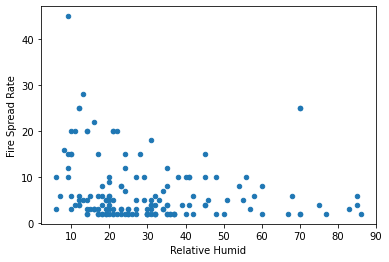

In [123]:
from pyspark.sql.types import IntegerType

wildlands_df_plot = wildlands_df_na.select("REL_HUMID", "SPREAD_RAT")

wildlands_df_plot = wildlands_df_plot.filter(wildlands_df_plot.SPREAD_RAT < 50).filter(wildlands_df_plot.SPREAD_RAT > 1)
p_wildlands_df_na = wildlands_df_plot.toPandas()
p_wildlands_df_na = p_wildlands_df_na.astype(float)
ptest = p_wildlands_df_na.sort_values(by="REL_HUMID").plot.scatter(x="REL_HUMID", y="SPREAD_RAT", xlabel="Relative Humid", ylabel = "Fire Spread Rate", legend = False)
figtest = ptest.get_figure()

# Graph: Spread Rate vs Fuel Moisture

In [210]:
wildlands_df_na = wildlands_df.na.drop(subset=("FUEL_MOIST","SPREAD_RAT"))
wildlands_df_na.count()

747

In [211]:
wildlands_df_na.groupBy("FUEL_MOIST").count().show()

+----------+-----+
|FUEL_MOIST|count|
+----------+-----+
|         7|    6|
|         3|    3|
|         8|    5|
|         0|  633|
|         5|   14|
|         6|    9|
|        25|    2|
|         1|    2|
|        12|    3|
|         2|    4|
|        15|   10|
|        18|    2|
|        75|    1|
|        60|    3|
|        68|    1|
|        84|    1|
|         9|    3|
|        20|    5|
|        10|   11|
|         4|    6|
+----------+-----+
only showing top 20 rows



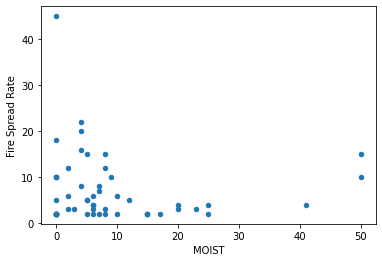

In [130]:
wildlands_df_plot = wildlands_df_na.select("FUEL_MOIST", "SPREAD_RAT")
wildlands_df_plot = wildlands_df_plot.filter(wildlands_df_plot.SPREAD_RAT < 50).filter(wildlands_df_plot.SPREAD_RAT > 1)
p_wildlands_df_na = wildlands_df_plot.toPandas()
p_wildlands_df_na = p_wildlands_df_na.astype(float)
ptest = p_wildlands_df_na.sort_values(by="FUEL_MOIST").plot.scatter(x="FUEL_MOIST", y="SPREAD_RAT", xlabel="MOIST", ylabel = "Fire Spread Rate", legend = False)
figtest = ptest.get_figure()

# Graph : Human Factors vs Count

In [139]:
ems_df = spark.read.options(delimiter="^", header=True).csv("ems.txt")
ems_df.count()

2031

In [204]:
ems_df_combine = ems_df.select(F.explode(F.array(ems_df.HUM_FACT1, ems_df.HUM_FACT2, ems_df.HUM_FACT3, ems_df.HUM_FACT4, ems_df.HUM_FACT5, ems_df.HUM_FACT6, ems_df.HUM_FACT7, ems_df.HUM_FACT8)).alias("HumanFactors"))
ems_df_comb_na = ems_df_combine.na.drop(subset=("HumanFactors"))

ems_df_comb_na = ems_df_comb_na.filter(ems_df_comb_na.HumanFactors != "N")
ems_df_comb_na = ems_df_comb_na.groupBy("HumanFactors").count()


In [205]:
p_ems_df = ems_df_comb_na.toPandas()
p_ems_df

,HumanFactors,count
0,3,26
1,8,10
2,5,14
3,6,16
4,1,20
5,4,26
6,2,6


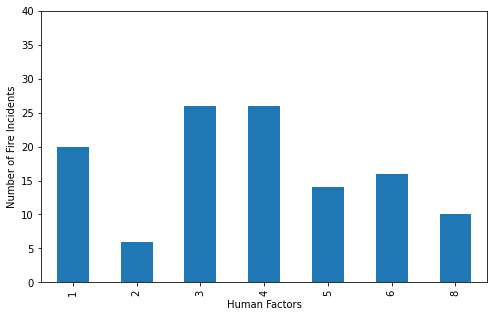

In [238]:
p_ems_df = ems_df_comb_na.toPandas()

# p_ems_df = p_ems_df.astype(float)
ptest = p_ems_df.sort_values(by="HumanFactors").plot(x="HumanFactors", y="count", xlabel="Human Factors", ylabel = "Number of Fire Incidents", legend = False, kind="bar", ylim=(0,40),figsize=(8,5))
fig1 = ptest.get_figure()
fig1.savefig("human_factors_number.png")

# Graph: Cause vs Count

In [192]:
ignition_cause.show()

+--------------------+-----+-----+--------+------+------+-------+--------+-------+----------+----------+----------+----------+---------+----------+---------+----------+---------+---------+----------+---------+---------+--------+---------+----------+----------+---------+---------+---------+---------+---------+---------+---------+---------+----+----+---------+---------+---------+---------+---------+--------+--------+-------------+--------+----------+---------+----------+--------+--------+---------+-------+--------+-------+---------+----------+----------+----------+----------+---------+----------+---------+---------+----------+----------+----------+----------+----------+---------+--------+--------+--------+---------+----------+----------+--------+--------+--------+--------+---------+--------+
|        INCIDENT_KEY|STATE| FDID|INC_DATE|INC_NO|EXP_NO|VERSION|NUM_UNIT|NOT_RES|BLDG_INVOL|ACRES_BURN|LESS_1ACRE|ON_SITE_M1|MAT_STOR1|ON_SITE_M2|MAT_STOR2|ON_SITE_M3|MAT_STOR3|AREA_ORIG|HEAT_SOURC|

In [193]:
ignition_cause = ignition_cause.groupBy("CAUSE_IGN").count()
ignition_cause.show()

+---------+------+
|CAUSE_IGN| count|
+---------+------+
|        3| 56107|
|        0|  8401|
|        5| 55852|
|        U|110306|
|        1| 67296|
|        4| 11135|
|        2|232727|
+---------+------+



In [224]:
p_ignition_cause = ignition_cause.toPandas()
p_ignition_cause["count"] = p_ignition_cause["count"]/1e03
# p_cause_loss_df["DLR_LOSS"]/1e05

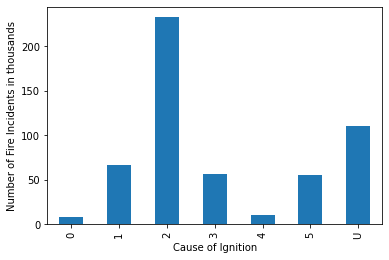

In [226]:
ptest = p_ignition_cause.sort_values(by="CAUSE_IGN").plot(x="CAUSE_IGN", y="count", xlabel="Cause of Ignition", ylabel = "Number of Fire Incidents in thousands", legend = False, kind="bar")
fig1 = ptest.get_figure()
fig1.savefig("cause_ignition_number.png")

In [4]:
save_in_db("fig1", "p1")